In [40]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [41]:
import pandas as pd


edges_df = pd.read_csv("top200_edges.csv")
nodes_df = pd.read_csv("top200_nodes.csv")


relationships_df = pd.read_excel("top200_with_follow_relationships(final).xlsx")


print("Edges DataFrame:")
print(edges_df.info())
print(edges_df.head())

print("\nNodes DataFrame:")
print(nodes_df.info())
print(nodes_df.head())

print("\nRelationships DataFrame:")
print(relationships_df.info())
print(relationships_df.head())

Edges DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   follower  382 non-null    object
 1   followed  382 non-null    object
dtypes: object(2)
memory usage: 6.1+ KB
None
        follower     followed
0    kyliejenner    cristiano
1       leomessi    cristiano
2    selenagomez  kyliejenner
3        therock  selenagomez
4  kimkardashian  selenagomez

Nodes DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   username         199 non-null    object 
 1   followers        199 non-null    int64  
 2   posts            199 non-null    int64  
 3   likes_avg        199 non-null    float64
 4   engagement_rate  199 non-null    float64
 5   boost_index      199 non-null    int64  
 6   comment

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import train_test_split_edges, negative_sampling

import shap
from captum.attr import IntegratedGradients, GradientShap

In [43]:

np.random.seed(42)
torch.manual_seed(42)

print("=" * 60)
print("Instagram Follower Growth Prediction Experiment")
print("=" * 60)

class DataProcessor:
    

    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def load_and_merge_data(self, edges_file, nodes_file, relationships_file):
       
        print("Loading data...")

      
        edges_df = pd.read_csv(edges_file)
        nodes_df = pd.read_csv(nodes_file)
        relationships_df = pd.read_excel(relationships_file)

        print(f"Edge Data: {edges_df.shape}")
        print(f"Node Data: {nodes_df.shape}")
        print(f"Relationship Data: {relationships_df.shape}")

        return edges_df, nodes_df, relationships_df

    def create_node_features(self, nodes_df, relationships_df):
        
        print("Creating node features...")

        # Merge nodes and relationships data
        # Unify the username format first
        nodes_df['username_lower'] = nodes_df['username'].str.lower()
        relationships_df['username_lower'] = relationships_df['Username'].str.lower()

        # merge
        merged_df = pd.merge(nodes_df, relationships_df,
                           left_on='username_lower',
                           right_on='username_lower',
                           how='inner')

        feature_columns = [
            'followers', 'posts', 'comments_avg', 'engagement_rate',
                   'in_degree', 'out_degree', 'pagerank', 'Betweenness', 'clustering'
        ]

      
        for col in feature_columns:
            if col in merged_df.columns:
                merged_df[col] = merged_df[col].fillna(merged_df[col].median())

        # Calculate follower growth rate (used as the target variable)
        # Assuming potential growth is based on the number of followers
        merged_df['follower_growth_rate'] = np.log1p(merged_df['followers']) * merged_df['engagement_rate']

        # Create binary classification labels (top 25% classified as rapid growth)
        growth_threshold = merged_df['follower_growth_rate'].quantile(0.75)
        merged_df['is_fast_growth'] = (merged_df['follower_growth_rate'] >= growth_threshold).astype(int)

        return merged_df, feature_columns

    def create_edge_index(self, edges_df, username_to_idx):
        
        print("Creating edge index...")

        edge_list = []
        for _, row in edges_df.iterrows():
            follower = row['follower'].lower()
            followed = row['followed'].lower()

            if follower in username_to_idx and followed in username_to_idx:
                edge_list.append([username_to_idx[follower], username_to_idx[followed]])

        if edge_list:
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)

        print(f"Number of valid edges: {edge_index.shape[1]}")
        return edge_index

    def prepare_graph_data(self, merged_df, feature_columns, edge_index):
   
        print("Preparing graph data...")

       # Standardize features
        features_array = merged_df[feature_columns].values
        features_scaled = self.scaler.fit_transform(features_array)

        # Convert to PyTorch Tensor
        x = torch.tensor(features_scaled, dtype=torch.float)
        y_regression = torch.tensor(merged_df['follower_growth_rate'].values, dtype=torch.float)
        y_classification = torch.tensor(merged_df['is_fast_growth'].values, dtype=torch.long)

      
        data = Data(x=x, edge_index=edge_index,
                   y_reg=y_regression, y_cls=y_classification)

        return data, features_scaled, merged_df[feature_columns].values

Instagram Follower Growth Prediction Experiment


In [44]:
class GNNModels:
    

    class GCN(nn.Module):
        def __init__(self, input_dim, hidden_dim=128, output_dim=1, num_layers=2, dropout=0.3):
            super().__init__()
            self.num_layers = num_layers
            self.dropout = dropout

            self.convs = nn.ModuleList()
            self.convs.append(GCNConv(input_dim, hidden_dim))#firstn layer

            for _ in range(num_layers - 2):
                self.convs.append(GCNConv(hidden_dim, hidden_dim))#middle layer

            self.convs.append(GCNConv(hidden_dim, hidden_dim))#last layer

            # classification and regression head
            self.classifier = nn.Linear(hidden_dim, 2)  # binary classification
            self.regressor = nn.Linear(hidden_dim, 1)   # regression

        def forward(self, x, edge_index, task='classification'):
            for i, conv in enumerate(self.convs):
                x = conv(x, edge_index)
                if i < len(self.convs) - 1:
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)

            if task == 'classification':
                return self.classifier(x)
            else:
                return self.regressor(x)

    class GAT(nn.Module):
        def __init__(self, input_dim, hidden_dim=128, output_dim=1, num_layers=2,
                     heads=8, dropout=0.3):
            super().__init__()
            self.num_layers = num_layers
            self.dropout = dropout

            self.convs = nn.ModuleList()
            self.convs.append(GATConv(input_dim, hidden_dim//heads, heads=heads, dropout=dropout))#concat

            for _ in range(num_layers - 2):
                self.convs.append(GATConv(hidden_dim, hidden_dim//heads, heads=heads, dropout=dropout))

            self.convs.append(GATConv(hidden_dim, hidden_dim, heads=1, dropout=dropout))#no concat

            # classification and regression head
            self.classifier = nn.Linear(hidden_dim, 2)
            self.regressor = nn.Linear(hidden_dim, 1)

        #same with GCN
        def forward(self, x, edge_index, task='classification'):
            for i, conv in enumerate(self.convs):
                x = conv(x, edge_index)
                if i < len(self.convs) - 1:
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)

            if task == 'classification':
                return self.classifier(x)
            else:
                return self.regressor(x)

In [45]:
class ModelTrainer:

    def __init__(self, device='cpu'):
        self.device = device

    def train_gnn_model(self, model, data, epochs=200, lr=0.001):
        """training GNN model"""
        print(f"Training in progress {model.__class__.__name__} model...")

        model = model.to(self.device)
        data = data.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # split data
        num_nodes = data.x.shape[0]
        indices = torch.randperm(num_nodes)

        train_size = int(0.7 * num_nodes)#training
        val_size = int(0.15 * num_nodes)#validation

        train_idx = indices[:train_size]
        val_idx = indices[train_size:train_size+val_size]
        test_idx = indices[train_size+val_size:]

        best_val_loss = float('inf')
        patience = 20
        patience_counter = 0

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            # classification loss
            out_cls = model(data.x, data.edge_index, task='classification')
            loss_cls = F.cross_entropy(out_cls[train_idx], data.y_cls[train_idx])

            # regrssion loss
            out_reg = model(data.x, data.edge_index, task='regression')
            loss_reg = F.mse_loss(out_reg[train_idx].squeeze(), data.y_reg[train_idx])

            # total loss
            total_loss = loss_cls + loss_reg
            total_loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                val_out_cls = model(data.x, data.edge_index, task='classification')
                val_loss_cls = F.cross_entropy(val_out_cls[val_idx], data.y_cls[val_idx])

                val_out_reg = model(data.x, data.edge_index, task='regression')
                val_loss_reg = F.mse_loss(val_out_reg[val_idx].squeeze(), data.y_reg[val_idx])

                val_loss = val_loss_cls + val_loss_reg

            train_losses.append(total_loss.item())
            val_losses.append(val_loss.item())

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f'best_{model.__class__.__name__.lower()}_model.pth')
            else:
                patience_counter += 1 #Early Stopping（if no improvement after 20 times）

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")#
                break

            if epoch % 50 == 0:
                print(f'Epoch {epoch:03d}, Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}')

        # load best model
        model.load_state_dict(torch.load(f'best_{model.__class__.__name__.lower()}_model.pth'))

        return model, (train_idx, val_idx, test_idx), (train_losses, val_losses)

    def evaluate_gnn_model(self, model, data, test_idx):
        """evaluate GNN  model"""
        model.eval()
        data = data.to(self.device)

        with torch.no_grad():
            # classification evaluate
            out_cls = model(data.x, data.edge_index, task='classification')
            pred_cls = out_cls[test_idx].argmax(dim=1).cpu().numpy() #Select the class index with the highest probability as the predicted label
            true_cls = data.y_cls[test_idx].cpu().numpy()

            cls_metrics = {
                'accuracy': accuracy_score(true_cls, pred_cls),
                'precision': precision_score(true_cls, pred_cls, average='weighted', zero_division=0),
                'recall': recall_score(true_cls, pred_cls, average='weighted', zero_division=0),
                'f1': f1_score(true_cls, pred_cls, average='weighted', zero_division=0)
            }

            # regression evaluate
            out_reg = model(data.x, data.edge_index, task='regression')
            pred_reg = out_reg[test_idx].squeeze().cpu().numpy()
            true_reg = data.y_reg[test_idx].cpu().numpy()

            reg_metrics = {
                'mse': mean_squared_error(true_reg, pred_reg),
                'r2': r2_score(true_reg, pred_reg),
                'pcc': pearsonr(true_reg, pred_reg)[0] if len(true_reg) > 1 else 0
            }

        return cls_metrics, reg_metrics, (pred_cls, true_cls), (pred_reg, true_reg)

    def train_traditional_models(self, X_train, X_val, X_test, y_cls_train, y_cls_val, y_cls_test,
                                y_reg_train, y_reg_val, y_reg_test):
        """train traditional ML model"""
        print("Training traditional machine learning models...")

        results = {}

        # RF
        print("Training Random Forest model...")
        rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

        rf_cls.fit(X_train, y_cls_train)
        rf_reg.fit(X_train, y_reg_train)

        # evaluate RF
        rf_pred_cls = rf_cls.predict(X_test)
        rf_pred_reg = rf_reg.predict(X_test)

        results['RandomForest'] = {
            'classification': {
                'accuracy': accuracy_score(y_cls_test, rf_pred_cls),
                'precision': precision_score(y_cls_test, rf_pred_cls, average='weighted', zero_division=0),
                'recall': recall_score(y_cls_test, rf_pred_cls, average='weighted', zero_division=0),
                'f1': f1_score(y_cls_test, rf_pred_cls, average='weighted', zero_division=0)
            },
            'regression': {
                'mse': mean_squared_error(y_reg_test, rf_pred_reg),
                'r2': r2_score(y_reg_test, rf_pred_reg),
                'pcc': pearsonr(y_reg_test, rf_pred_reg)[0] if len(y_reg_test) > 1 else 0
            },
            'models': (rf_cls, rf_reg),
            'predictions': (rf_pred_cls, rf_pred_reg)
        }

        # SVM
        print("Training SVM model...")
        svm_cls = SVC(kernel='rbf',probability=True, random_state=42)
        svm_reg = SVR(kernel='rbf')

        svm_cls.fit(X_train, y_cls_train)
        svm_reg.fit(X_train, y_reg_train)

        # evaluate SVM
        svm_pred_cls = svm_cls.predict(X_test)
        svm_pred_reg = svm_reg.predict(X_test)

        results['SVM'] = {
            'classification': {
                'accuracy': accuracy_score(y_cls_test, svm_pred_cls),
                'precision': precision_score(y_cls_test, svm_pred_cls, average='weighted', zero_division=0),
                'recall': recall_score(y_cls_test, svm_pred_cls, average='weighted', zero_division=0),
                'f1': f1_score(y_cls_test, svm_pred_cls, average='weighted', zero_division=0)
            },
            'regression': {
                'mse': mean_squared_error(y_reg_test, svm_pred_reg),
                'r2': r2_score(y_reg_test, svm_pred_reg),
                'pcc': pearsonr(y_reg_test, svm_pred_reg)[0] if len(y_reg_test) > 1 else 0
            },
            'models': (svm_cls, svm_reg),
            'predictions': (svm_pred_cls, svm_pred_reg)
        }

        return results
    

In [46]:
class ExplainabilityAnalyzer:

    def __init__(self, feature_names):
        self.feature_names = feature_names

    def analyze_traditional_models(self, model_results, X_test, y_cls_test, y_reg_test):
        """traditional model"""
        print("Performing SHAP analysis on traditional models...")

        shap_results = {}

        for model_name, results in model_results.items():
            print(f"Analyzing  {model_name} model...")

            cls_model, reg_model = results['models']

            # Classification model SHAP analysis
            # Only the first 50 samples of the test set are used to calculate the SHAP value (to speed up the calculation).
            try:
                if model_name == 'RandomForest':
                    explainer_cls = shap.TreeExplainer(cls_model)
                    explainer_reg = shap.TreeExplainer(reg_model)
                else:  # SVM
                    explainer_cls = shap.KernelExplainer(cls_model.predict_proba, X_test[:50])
                    explainer_reg = shap.KernelExplainer(reg_model.predict, X_test[:50])

                shap_values_cls = explainer_cls.shap_values(X_test[:50])
                shap_values_reg = explainer_reg.shap_values(X_test[:50])

                # If it is multi-classification, take the SHAP value of the positive class
                if isinstance(shap_values_cls, list):
                    shap_values_cls = shap_values_cls[1]  # choose positive class

                shap_results[model_name] = {
                    'classification_shap': shap_values_cls,
                    'regression_shap': shap_values_reg,
                    'explainer_cls': explainer_cls,
                    'explainer_reg': explainer_reg
                }

            except Exception as e:
                print(f"Error during SHAP analysis of {model_name}: {e}")
                continue

        return shap_results

    def analyze_gnn_models(self, models, data, test_idx):
        """GNN (Captum)"""
        print("Performing explainability analysis of the GNN model...")

        gnn_explanations = {}

        for model_name, model in models.items():
            print(f"Analyzing {model_name} model...")

            model.eval()

            # use IntegratedGradients
            def forward_func_cls(x):
                return model(x, data.edge_index, task='classification')

            def forward_func_reg(x):
                return model(x, data.edge_index, task='regression')

            try:
                ig_cls = IntegratedGradients(forward_func_cls)
                ig_reg = IntegratedGradients(forward_func_reg)

                # Select 20 samples in the test set for analysis
                sample_indices = test_idx[:20] if len(test_idx) >= 20 else test_idx
                sample_input = data.x[sample_indices]

                # Feature Importance for Classification 
                baseline = torch.zeros_like(sample_input)
                attributions_cls = ig_cls.attribute(sample_input, baseline, target=1)

                # Feature Importance for Regression
                attributions_reg = ig_reg.attribute(sample_input, baseline)

                gnn_explanations[model_name] = {
                    'classification_attributions': attributions_cls.detach().cpu().numpy(),
                    'regression_attributions': attributions_reg.detach().cpu().numpy(),
                    'sample_indices': sample_indices.cpu().numpy()
                }

            except Exception as e:
                print(f"Error during GNN explainability analysis of {model_name}: {e}")
                continue

        return gnn_explanations

    def plot_feature_importance(self, shap_results, gnn_explanations):
        """Plotting feature importance comparison"""
        print("Plotting feature importance comparison chart...")
    
        try:
            # compute feature importance of each model
            importance_data = {}
    
            # address traditional model SHAP outcome
            for model_name, results in shap_results.items():
                try:
                    shap_values = results['classification_shap']
    
                    # address different dimension SHAP value
                    if isinstance(shap_values, list):
                        # # If it is multi-classification, take choose the positive class
                        shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    
                    if len(shap_values.shape) == 2:
                        mean_importance = np.abs(shap_values).mean(axis=0)
                    elif len(shap_values.shape) == 1:
                        mean_importance = np.abs(shap_values)
                    else:
                        print(f"Skipping {model_name}: unsupported SHAP values dimension {shap_values.shape}")
                        continue
    
                    # ensure the lengths match
                    if len(mean_importance) == len(self.feature_names):
                            importance_data[model_name] = mean_importance
                            print(f"\nFeature importance (SHAP relevance score) of {model_name}:")
                            for fname, val in zip(self.feature_names, mean_importance):
                                print(f"  {fname}: {val:.4f}")
                    else:
                        print(f"Skipping {model_name}: feature count mismatch")
    
                except Exception as e:
                    print(f"Error processing SHAP results for {model_name}: {e}")
                    continue
    
            # address GNN model attribution outcome
            for model_name, results in gnn_explanations.items():
                try:
                    attributions = results['classification_attributions']
    
                    if len(attributions.shape) == 2:
                        mean_importance = np.abs(attributions).mean(axis=0)
                    elif len(attributions.shape) == 1:
                        mean_importance = np.abs(attributions)
                    else:
                        print(f"Skipping {model_name}: Unsupported attribution dimensions {attributions.shape}")
                        continue
    
                    # ensure the lengths match
                    if len(mean_importance) == len(self.feature_names):
                        importance_data[model_name] = mean_importance
                        print(f"\n{model_name}'s feature importance (GNN Attribution score):")
                        for fname, val in zip(self.feature_names, mean_importance):
                            print(f"  {fname}: {val:.4f}")
                    else:
                        print(f"Skipping {model_name}: Feature count mismatch")
    
                except Exception as e:
                    print(f"Error processing {model_name} attribution results: {e}")
                    continue
    
            # If no available data, return
            if not importance_data:
                print("No valid feature importance data available for plotting")
                return
    
            # plotting feature importance comparison
            n_models = len(importance_data)
            n_cols = min(2, n_models)
            n_rows = (n_models + 1) // 2
    
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    
            # ensure axes is an array
            if n_models == 1:
                axes = [axes]
            elif n_rows == 1:
                axes = axes if isinstance(axes, np.ndarray) else [axes]
            else:
                axes = axes.flatten()
    
            for i, (model_name, importance) in enumerate(importance_data.items()):
                # sorted feature importance
                sorted_idx = np.argsort(importance)[::-1]
                sorted_features = [self.feature_names[j] for j in sorted_idx]
                sorted_importance = importance[sorted_idx]
    
                axes[i].barh(sorted_features, sorted_importance)
                axes[i].set_title(f'{model_name} - Feature Importance')
                axes[i].set_xlabel('Importance Score')
    
                # add value labels
                for j, v in enumerate(sorted_importance):
                    axes[i].text(v, j, f'{v:.3f}', va='center', ha='left', fontsize=8)
    
            # hide redundant sub-images
            for i in range(n_models, len(axes)):
                axes[i].axis('off')
    
            plt.tight_layout()
            plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()
    
            print("Feature importance comparison plot completed")
    
        except Exception as e:
            print(f"Error occurred while plotting feature importance: {e}")
            print("Trying a simplified version...")
    
            # sample version: only display values
            print("\nFeature importance values comparison:")
            for model_name, results in shap_results.items():
                try:
                    shap_values = results['classification_shap']
                    if isinstance(shap_values, list):
                        shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    
                    if len(shap_values.shape) >= 2:
                        mean_importance = np.abs(shap_values).mean(axis=0)
                        print(f"\n{model_name}:")
                        for i, importance in enumerate(mean_importance[:len(self.feature_names)]):
                            print(f"  {self.feature_names[i]}: {importance:.4f}")
                except:
                    continue
    
            for model_name, results in gnn_explanations.items():
                try:
                    attributions = results['classification_attributions']
                    if len(attributions.shape) >= 2:
                        mean_importance = np.abs(attributions).mean(axis=0)
                        print(f"\n{model_name}:")
                        for i, importance in enumerate(mean_importance[:len(self.feature_names)]):
                            print(f"  {self.feature_names[i]}: {importance:.4f}")
                except:
                    continue

In [47]:
processor = DataProcessor()

# loading data
edges_df, nodes_df, relationships_df = processor.load_and_merge_data(
    "top200_edges.csv",
    "top200_nodes.csv",
    "top200_with_follow_relationships(final).xlsx"
)

Loading data...
Edge Data: (382, 2)
Node Data: (199, 8)
Relationship Data: (200, 28)


In [48]:
# create node feature
merged_df, feature_columns = processor.create_node_features(nodes_df, relationships_df)

# create a mapping from username to index
username_to_idx = {username.lower(): idx for idx, username in enumerate(merged_df['username_lower'])}

# create edge index
edge_index = processor.create_edge_index(edges_df, username_to_idx)

print(merged_df.columns.tolist())
# prepare graph data
data, features_scaled, features_original = processor.prepare_graph_data(
    merged_df, feature_columns, edge_index
)

Creating node features...
Creating edge index...
Number of valid edges: 382
['username', 'followers', 'posts', 'likes_avg', 'engagement_rate', 'boost_index', 'comments_avg', 'views_avg', 'username_lower', 'User No.', 'Username', 'Channel Name', 'Country', 'Url', 'Main topic', 'Main video category', 'Likes', 'Likes Avg.', 'Posts', 'Followers', 'Boost Index', 'Comments Avg.', 'Views Avg.', 'Avg. 1 Day', 'Avg. 3 Day', 'Avg. 7 Day', 'Avg. 14 Day', 'Avg. 30 Day', 'Engagement Rate', 'Engagement Rate (60 Days)', 'followers_list', 'following_list', 'pagerank', 'clustering', 'out_degree', 'in_degree', 'Betweenness', 'follower_growth_rate', 'is_fast_growth']
Preparing graph data...


In [49]:
print(f"Graph data information:")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of features: {data.x.shape[1]}")
print(f"Number of edges: {data.edge_index.shape[1]}")
print(f"Proportion of fast-growing users: {data.y_cls.float().mean():.3f}")

Graph data information:
Number of nodes: 199
Number of features: 9
Number of edges: 382
Proportion of fast-growing users: 0.251


In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Used device: {device}")

Used device: cpu


In [51]:
# initialize the model trainer
trainer = ModelTrainer(device)

# create and train GNN model
input_dim = data.x.shape[1]
# GCN model
gcn_model = GNNModels.GCN(input_dim)
gcn_trained, gcn_splits, gcn_losses = trainer.train_gnn_model(gcn_model, data)



Training in progress GCN model...
Epoch 000, Train Loss: 1.8402, Val Loss: 0.8334
Epoch 050, Train Loss: 0.7228, Val Loss: 0.4551
Early stopping at epoch 69


In [52]:
# GATmodel
gat_model = GNNModels.GAT(input_dim)
gat_trained, gat_splits, gat_losses = trainer.train_gnn_model(gat_model, data)

Training in progress GAT model...
Epoch 000, Train Loss: 1.5236, Val Loss: 0.8194
Epoch 050, Train Loss: 0.7802, Val Loss: 0.4584
Epoch 100, Train Loss: 0.7148, Val Loss: 0.4378
Early stopping at epoch 147


In [53]:
# split GCN node index into training set, validation set, and test set
# train_idx: node index used for training model
# val_idx: used to verify model effect (such as early stopping)
# test_idx: used for final test model performance
train_idx, val_idx, test_idx = gcn_splits

In [54]:
 # evalue GNN model
print("\n" + "="*50)
print("GNN model evaluation results")
print("="*50)

#Evaluate the classification and regression performance of the trained GCN model using the test set
gcn_cls_metrics, gcn_reg_metrics, gcn_cls_pred, gcn_reg_pred = trainer.evaluate_gnn_model(
    gcn_trained, data, test_idx
)

#Evaluate the classification and regression performance of the trained GAT model using the test set
gat_cls_metrics, gat_reg_metrics, gat_cls_pred, gat_reg_pred = trainer.evaluate_gnn_model(
    gat_trained, data, test_idx
)
print("GCN results:")
print(f"Classification - Accuracy: {gcn_cls_metrics['accuracy']:.4f}, F1: {gcn_cls_metrics['f1']:.4f}")
print(f"Regression - MSE: {gcn_reg_metrics['mse']:.4f}, PCC: {gcn_reg_metrics['pcc']:.4f}")

print("\nGAT results:")
print(f"Classification - Accuracy: {gat_cls_metrics['accuracy']:.4f}, F1: {gat_cls_metrics['f1']:.4f}")
print(f"Regression - MSE: {gat_reg_metrics['mse']:.4f}, PCC: {gat_reg_metrics['pcc']:.4f}")


GNN model evaluation results
GCN results:
Classification - Accuracy: 0.6452, F1: 0.5349
Regression - MSE: 0.2064, PCC: 0.4788

GAT results:
Classification - Accuracy: 0.8710, F1: 0.8642
Regression - MSE: 0.1061, PCC: 0.8363


In [55]:
 # prepare traditional model data (x:feature,y:label)
X_train = features_scaled[train_idx.cpu().numpy()]
X_val = features_scaled[val_idx.cpu().numpy()]
X_test = features_scaled[test_idx.cpu().numpy()]

#y_cls
y_cls_train = data.y_cls[train_idx].cpu().numpy()
y_cls_val = data.y_cls[val_idx].cpu().numpy()
y_cls_test = data.y_cls[test_idx].cpu().numpy()

#y_reg
y_reg_train = data.y_reg[train_idx].cpu().numpy()
y_reg_val = data.y_reg[val_idx].cpu().numpy()
y_reg_test = data.y_reg[test_idx].cpu().numpy()

# train
traditional_results = trainer.train_traditional_models(
    X_train, X_val, X_test, y_cls_train, y_cls_val, y_cls_test,
    y_reg_train, y_reg_val, y_reg_test
)

Training traditional machine learning models...
Training Random Forest model...
Training SVM model...


In [56]:
print("\n" + "="*50)
print("Traditional model evaluation results")
print("="*50)

for model_name, results in traditional_results.items():
    cls_metrics = results['classification']
    reg_metrics = results['regression']
    print(f"\n{model_name} results:")
    print(f"Classification - Accuracy: {cls_metrics['accuracy']:.4f}, F1: {cls_metrics['f1']:.4f}")
    print(f"Regression - MSE: {reg_metrics['mse']:.4f}, PCC: {reg_metrics['pcc']:.4f}")


Traditional model evaluation results

RandomForest results:
Classification - Accuracy: 1.0000, F1: 1.0000
Regression - MSE: 0.0029, PCC: 0.9957

SVM results:
Classification - Accuracy: 0.9032, F1: 0.8999
Regression - MSE: 0.0124, PCC: 0.9763


In [57]:
import numpy as np
if not hasattr(np, 'bool'):
    np.bool = bool
if not hasattr(np, 'int'):
    np.int = int


In [58]:
# create a result comparison table
print("\n" + "="*80)
print("Model Performance Comparison Table")
print("="*80)

comparison_data = []

# GNN model outcome
comparison_data.append(['GCN', gcn_cls_metrics['accuracy'], gcn_cls_metrics['f1'],
                        gcn_reg_metrics['mse'], gcn_reg_metrics['pcc']])
comparison_data.append(['GAT', gat_cls_metrics['accuracy'], gat_cls_metrics['f1'],
                        gat_reg_metrics['mse'], gat_reg_metrics['pcc']])

# traditional model outcome
for model_name, results in traditional_results.items():
    comparison_data.append([model_name,
                            results['classification']['accuracy'],
                            results['classification']['f1'],
                            results['regression']['mse'],
                            results['regression']['pcc']])

# comparison table
print(f"{'Model':<12} {'Accuracy':<10} {'F1 Score':<10} {'MSE':<12} {'PCC':<10}")
print("-" * 60)
for row in comparison_data:
    print(f"{row[0]:<12} {row[1]:<10.4f} {row[2]:<10.4f} {row[3]:<12.4f} {row[4]:<10.4f}")

print("\n" + "="*50)
print("Explainability analysis")
print("="*50)

analyzer = ExplainabilityAnalyzer(feature_columns)

# t_m SHAP analysis
# Exclude SVM from SHAP analysis as it doesn't have predict_proba
shap_results = {}
for model_name, results in traditional_results.items():
    if model_name != 'SVM':
        try:
            shap_results[model_name] = analyzer.analyze_traditional_models(
                {model_name: results}, X_test, y_cls_test, y_reg_test
            )[model_name]
        except Exception as e:
            print(f"SHAP analysis {model_name} Error: {e}")
    else:
        print("Skipping SHAP analysis for the SVM model since it does not have a predict_proba method.")


gnn_models = {
    'GCN': gcn_trained,
    'GAT': gat_trained
}

gnn_explanations = analyzer.analyze_gnn_models(gnn_models, data, test_idx)


Model Performance Comparison Table
Model        Accuracy   F1 Score   MSE          PCC       
------------------------------------------------------------
GCN          0.6452     0.5349     0.2064       0.4788    
GAT          0.8710     0.8642     0.1061       0.8363    
RandomForest 1.0000     1.0000     0.0029       0.9957    
SVM          0.9032     0.8999     0.0124       0.9763    

Explainability analysis
Performing SHAP analysis on traditional models...
Analyzing  RandomForest model...
Skipping SHAP analysis for the SVM model since it does not have a predict_proba method.
Performing explainability analysis of the GNN model...
Analyzing GCN model...
Analyzing GAT model...


Drawing feature importance comparison...
RandomForest SHAP shape: (31, 9)
GCN Attribution shape: (20, 9)
GAT Attribution shape: (20, 9)
Feature columns count: 9
Feature columns: ['followers', 'posts', 'comments_avg', 'engagement_rate', 'in_degree', 'out_degree', 'pagerank', 'Betweenness', 'clustering']

=== Feature Importance Comparison ===

RandomForest:
  Importance array shape: (9,)
  Importance array length: 9
  Top 5 Important Features:
    1. engagement_rate: 0.3170
    2. posts: 0.0644
    3. comments_avg: 0.0354
    4. followers: 0.0165
    5. in_degree: 0.0043

GCN:
  Importance array shape: (9,)
  Importance array length: 9
  Top 5 Important Features:
    1. engagement_rate: 0.1884
    2. comments_avg: 0.1330
    3. in_degree: 0.1080
    4. posts: 0.1061
    5. out_degree: 0.0800

GAT:
  Importance array shape: (9,)
  Importance array length: 9
  Top 5 Important Features:
    1. engagement_rate: 0.4364
    2. out_degree: 0.2501
    3. in_degree: 0.2499
    4. followers: 0.238

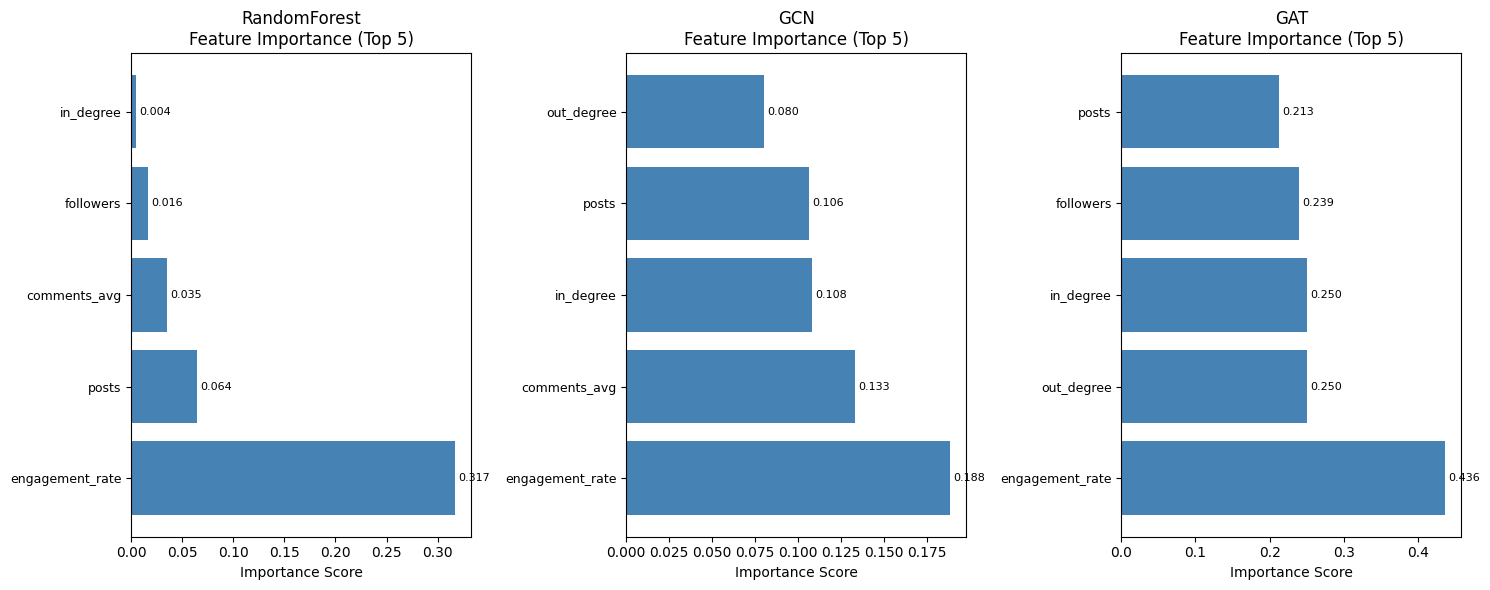

In [59]:

print("Drawing feature importance comparison...")

# collect feature importance data for all models
importance_dict = {}

# address t_m
for model_name, results in shap_results.items():
    try:
        shap_values = results['classification_shap']
        print(f"{model_name} SHAP shape: {shap_values.shape}")

        if isinstance(shap_values, list):
            shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]

        # handling 3D SHAP values ​​(RF case)
        if len(shap_values.shape) == 3:
            # take the SHAP value of the positive class (the second category)
            shap_values_2d = shap_values[:, :, 1]
            mean_importance = np.abs(shap_values_2d).mean(axis=0)
        elif len(shap_values.shape) == 2:
            # handling 2D SHAP values
            if shap_values.shape[1] == 2:
                # if there are 2 columns, take the positive class
                mean_importance = np.abs(shap_values[:, 1])
            else:
                mean_importance = np.abs(shap_values).mean(axis=0)
        else:
            mean_importance = np.abs(shap_values)

        importance_dict[model_name] = mean_importance[:len(feature_columns)]

    except Exception as e:
        print(f"Error processing {model_name}: {e}")

# address GNN model
for model_name, results in gnn_explanations.items():
    try:
        attributions = results['classification_attributions']
        if len(attributions.shape) >= 2:
            mean_importance = np.abs(attributions).mean(axis=0)
            importance_dict[model_name] = mean_importance[:len(feature_columns)]
        print(f"{model_name} Attribution shape: {attributions.shape}")
    except Exception as e:
        print(f"Error processing {model_name}: {e}")

print(f"Feature columns count: {len(feature_columns)}")
print(f"Feature columns: {feature_columns}")

# plotting and printing results
if importance_dict:
    print("\n=== Feature Importance Comparison ===")

    n_models = len(importance_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 6))

    if n_models == 1:
        axes = [axes]

    for i, (model_name, importance) in enumerate(importance_dict.items()):
        print(f"\n{model_name}:")
        print(f"  Importance array shape: {importance.shape}")
        print(f"  Importance array length: {len(importance)}")

        # make sure the importance array is the correct length
        if len(importance) != len(feature_columns):
            print(f"  Warning: Length mismatch, taking first {min(len(importance), len(feature_columns))}")
            min_len = min(len(importance), len(feature_columns))
            importance = importance[:min_len]
            current_features = feature_columns[:min_len]
        else:
            current_features = feature_columns

        # choose the top 5 most important features
        try:
            # ensure importance is a 1-dimensional array
            if len(importance.shape) > 1:
                importance = importance.flatten()

            top_indices = np.argsort(importance)[-5:][::-1]
            top_features = [current_features[j] for j in top_indices]
            top_values = [float(importance[j]) for j in top_indices]  

            # plotting
            bars = axes[i].barh(top_features, top_values, color='steelblue')
            axes[i].set_title(f'{model_name}\nFeature Importance (Top 5)', fontsize=12)
            axes[i].set_xlabel('Importance Score', fontsize=10)
            axes[i].tick_params(axis='y', labelsize=9)

            # add value labels
            for j, v in enumerate(top_values):
                axes[i].text(v + max(top_values)*0.01, j, f'{v:.3f}',
                           va='center', ha='left', fontsize=8)

            # numerical results
            print(f"  Top 5 Important Features:")
            for j, (feat, val) in enumerate(zip(top_features, top_values)):
                print(f"    {j+1}. {feat}: {val:.4f}")

        except Exception as e:
            print(f"  Error processing {model_name} feature importance: {e}")
            # if an error occurs, an empty image is displayed.
            axes[i].text(0.5, 0.5, f'Error processing\n{model_name}',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{model_name}\n(Processing Error)', fontsize=12)
            continue

    plt.tight_layout()
    plt.savefig('feature_importance_comparison_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("No available feature importance data")

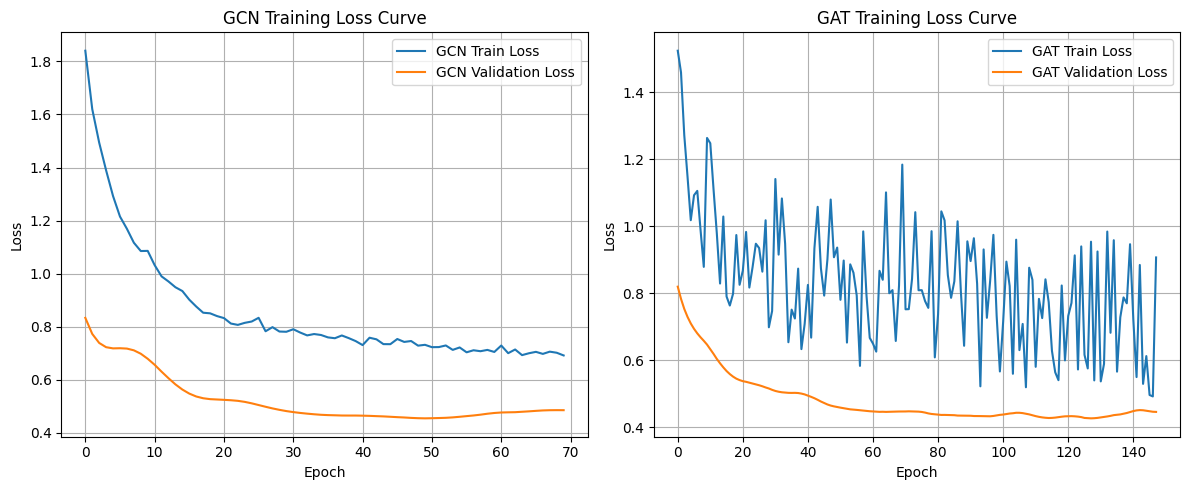

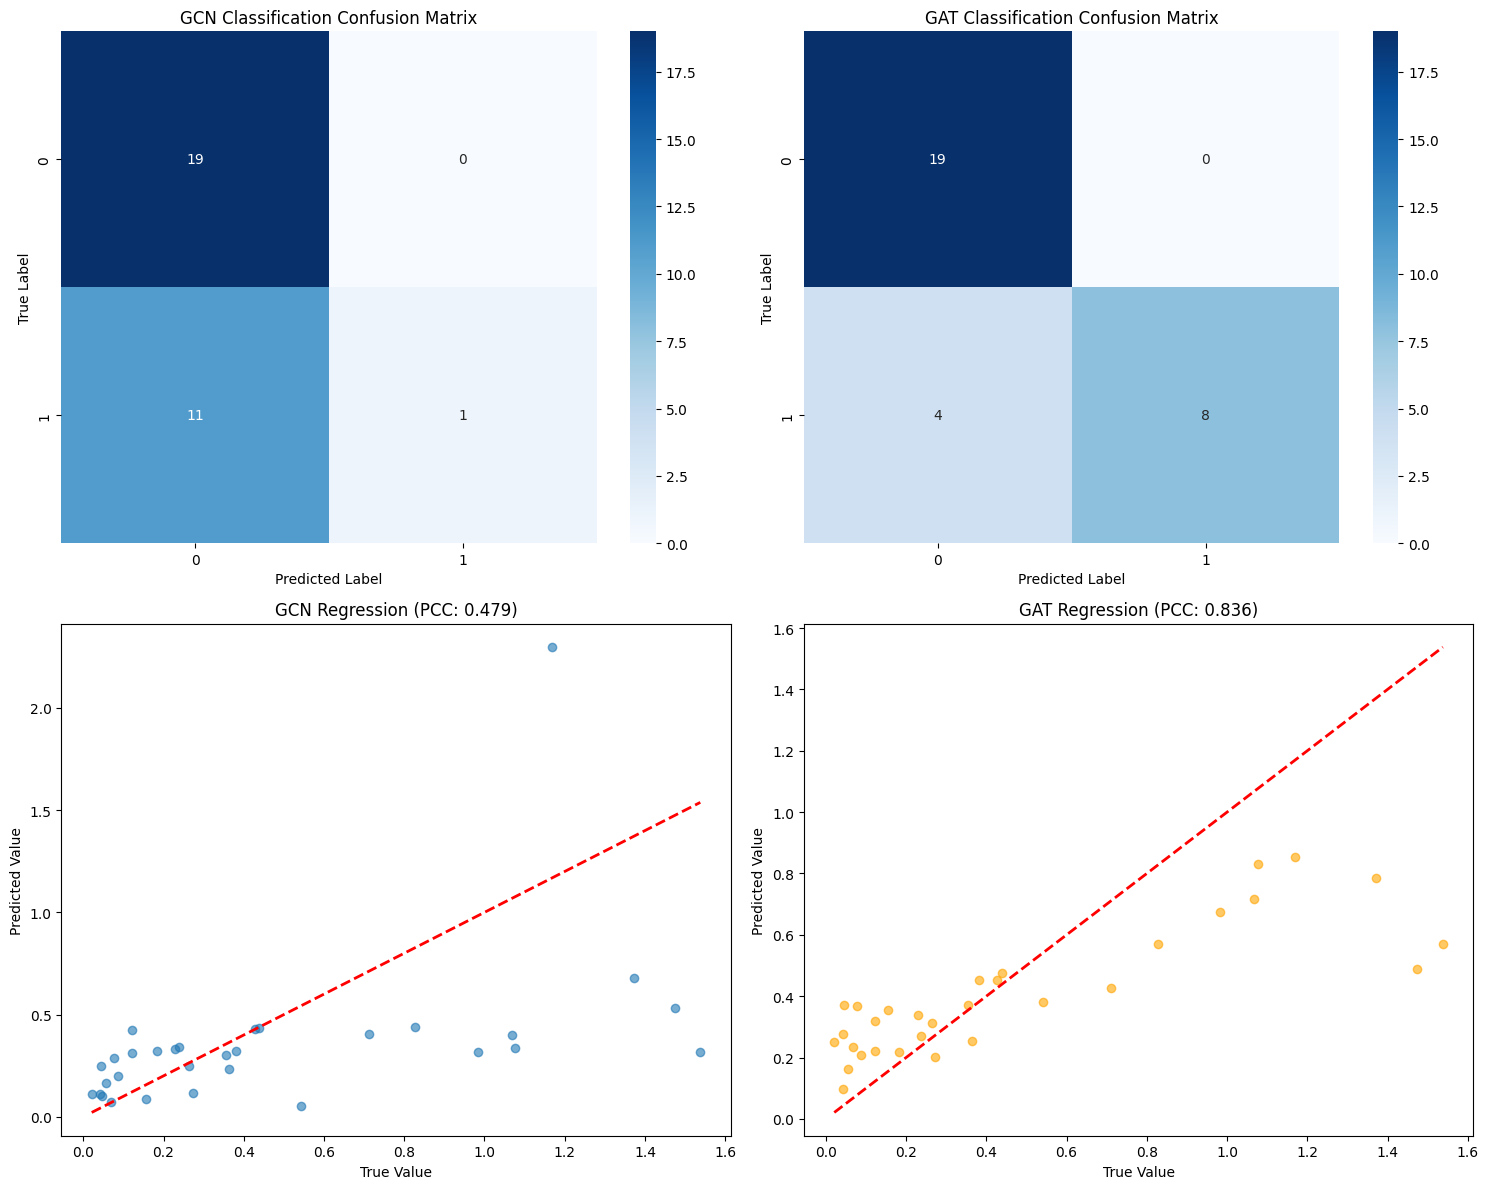

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gcn_losses[0], label='GCN Train Loss')
plt.plot(gcn_losses[1], label='GCN Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Training Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(gat_losses[0], label='GAT Train Loss')
plt.plot(gat_losses[1], label='GAT Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAT Training Loss Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot classification and regression results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion matrix: GCN
gcn_cm = confusion_matrix(gcn_cls_pred[1], gcn_cls_pred[0])
sns.heatmap(gcn_cm, annot=True, fmt='d', ax=axes[0, 0], cmap='Blues')
axes[0, 0].set_title('GCN Classification Confusion Matrix')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')

# Confusion matrix: GAT
gat_cm = confusion_matrix(gat_cls_pred[1], gat_cls_pred[0])
sns.heatmap(gat_cm, annot=True, fmt='d', ax=axes[0, 1], cmap='Blues')
axes[0, 1].set_title('GAT Classification Confusion Matrix')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_ylabel('True Label')

# Regression scatter plot: GCN
axes[1, 0].scatter(gcn_reg_pred[1], gcn_reg_pred[0], alpha=0.6)
axes[1, 0].plot([gcn_reg_pred[1].min(), gcn_reg_pred[1].max()],
                [gcn_reg_pred[1].min(), gcn_reg_pred[1].max()], 'r--', lw=2)
axes[1, 0].set_xlabel('True Value')
axes[1, 0].set_ylabel('Predicted Value')
axes[1, 0].set_title(f'GCN Regression (PCC: {gcn_reg_metrics["pcc"]:.3f})')

# Regression scatter plot: GAT
axes[1, 1].scatter(gat_reg_pred[1], gat_reg_pred[0], alpha=0.6, color='orange')
axes[1, 1].plot([gat_reg_pred[1].min(), gat_reg_pred[1].max()],
                [gat_reg_pred[1].min(), gat_reg_pred[1].max()], 'r--', lw=2)
axes[1, 1].set_xlabel('True Value')
axes[1, 1].set_ylabel('Predicted Value')
axes[1, 1].set_title(f'GAT Regression (PCC: {gat_reg_metrics["pcc"]:.3f})')

plt.tight_layout()
plt.savefig('prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()


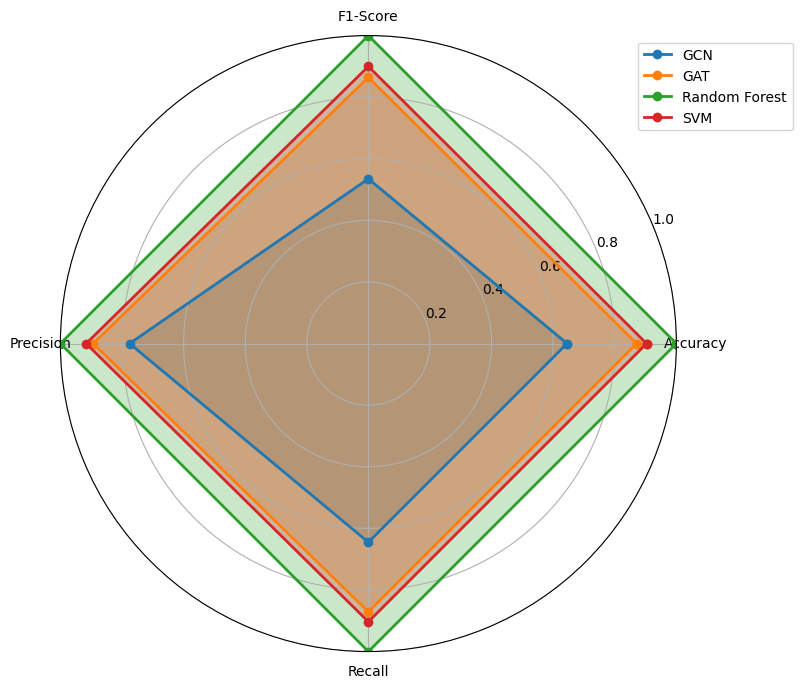

In [61]:
# Radar Chart
from math import pi

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))


metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

gcn_values = [gcn_cls_metrics['accuracy'], gcn_cls_metrics['f1'],
              gcn_cls_metrics['precision'], gcn_cls_metrics['recall']]
gat_values = [gat_cls_metrics['accuracy'], gat_cls_metrics['f1'],
              gat_cls_metrics['precision'], gat_cls_metrics['recall']]
rf_values = [traditional_results['RandomForest']['classification']['accuracy'],
              traditional_results['RandomForest']['classification']['f1'],
              traditional_results['RandomForest']['classification']['precision'],
              traditional_results['RandomForest']['classification']['recall']]
svm_values = [traditional_results['SVM']['classification']['accuracy'],
              traditional_results['SVM']['classification']['f1'],
              traditional_results['SVM']['classification']['precision'],
              traditional_results['SVM']['classification']['recall']]

# angle setting
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1] 

# add values
gcn_values += gcn_values[:1]
gat_values += gat_values[:1]
rf_values += rf_values[:1]
svm_values += svm_values[:1]


ax.plot(angles, gcn_values, 'o-', linewidth=2, label='GCN')
ax.fill(angles, gcn_values, alpha=0.25)

ax.plot(angles, gat_values, 'o-', linewidth=2, label='GAT')
ax.fill(angles, gat_values, alpha=0.25)

ax.plot(angles, rf_values, 'o-', linewidth=2, label='Random Forest')
ax.fill(angles, rf_values, alpha=0.25)

ax.plot(angles, svm_values, 'o-', linewidth=2, label='SVM')
ax.fill(angles, svm_values, alpha=0.25)


ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

plt.savefig('performance_radar.png', dpi=300, bbox_inches='tight')
plt.show()


In [62]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import shap
import matplotlib.pyplot as plt

In [63]:
# Data Simulation & Loading

edges_df = pd.read_csv("top200_edges.csv")
relationships_df = pd.read_excel("top200_with_follow_relationships(final).xlsx")

#Set Username as the node index
nodes_df = relationships_df.set_index('Username')[
    ['Followers', 'Posts', 'Likes Avg.', 'Comments Avg.', 'Engagement Rate',
     'in_degree', 'out_degree', 'pagerank', 'clustering', 'Betweenness']
]
nodes_df.columns = ['followers', 'posts', 'likes_avg', 'comments_avg', 'engagement_rate',
                    'in_degree', 'out_degree', 'pagerank', 'clustering', 'betweenness']

# Filter to keep only the nodes in the graph
users = pd.Index(edges_df['follower']).union(edges_df['followed']).unique()
nodes_df = nodes_df.loc[nodes_df.index.intersection(users)]

print("Node data (first 5 records):")
print(nodes_df.head())
print(f"\nNumber of edge data: {len(edges_df)}")
print("Edge data (first 5 records):")
print(edges_df.head())

Node data (first 5 records):
             followers  posts     likes_avg  comments_avg  engagement_rate  \
cristiano    465027234   3328  8.671953e+06  51758.330927         0.014916   
kyliejenner  356687629   6921  8.296736e+06  47534.120961         0.017617   
leomessi     347032978    875  6.895178e+06  47044.540305         0.015534   
selenagomez  334551681   1835  6.252711e+06  39167.115727         0.013913   
therock      327064138   6660  1.874151e+06   8529.747043         0.004426   

             in_degree  out_degree  pagerank  clustering  betweenness  
cristiano            9           0    0.1210      0.0417     0.000000  
kyliejenner          7           1    0.0836      0.0455     0.001469  
leomessi             1           1    0.0299      0.0714     0.000665  
selenagomez          7           1    0.0557      0.0278     0.001516  
therock              1           1    0.0195      0.0000     0.001308  

Number of edge data: 382
Edge data (first 5 records):
        followe

In [64]:

# build NetworkX directed graph
G = nx.from_pandas_edgelist(edges_df, source='follower', target='followed', create_using=nx.DiGraph())
G.add_nodes_from(nodes_df.index)

print(f"The graph is established. Number of nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")


The graph is established. Number of nodes: 199, edges: 382


In [65]:
#Data Preprocessing
#To avoid data leakage, we exclude 'likes_avg' from the feature set
feature_columns = [
    'followers', 'posts', 'comments_avg', 'engagement_rate',
    'in_degree', 'out_degree', 'pagerank', 'betweenness', 'clustering'
]
target_column = 'likes_avg'

X = nodes_df[feature_columns]
y = nodes_df[target_column]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=nodes_df.index, columns=feature_columns)

print("Dimensions of feature data (X):", X.shape)
print("Dimensions of target data (y):", y.shape)
print("\nStandardized feature data (first 5 records):")
print(X_scaled_df.head())

Dimensions of feature data (X): (199, 9)
Dimensions of target data (y): (199,)

Standardized feature data (first 5 records):
             followers     posts  comments_avg  engagement_rate  in_degree  \
cristiano     5.411727 -0.070871      3.267597        -0.224732   1.573098   
kyliejenner   3.903180  0.405622      2.939525        -0.157454   0.893301   
leomessi      3.768747 -0.396180      2.901502        -0.209343  -1.146090   
selenagomez   3.594954 -0.268868      2.289705        -0.249706   0.893301   
therock       3.490696  0.371009     -0.089736        -0.485951  -1.146090   

             out_degree  pagerank  betweenness  clustering  
cristiano     -2.299203  9.831869    -0.610971    0.705491  
kyliejenner   -1.101451  6.661128     0.327804    0.793102  
leomessi      -1.101451  2.108487    -0.185998    1.390243  
selenagomez   -1.101451  4.295790     0.357839    0.385017  
therock       -1.101451  1.226784     0.224916   -0.255929  


In [66]:
node_mapping = {node: i for i, node in enumerate(nodes_df.index)}
G_mapped = nx.relabel_nodes(G, node_mapping)

pyg_data = from_networkx(G_mapped)
pyg_data.x = torch.tensor(X_scaled, dtype=torch.float)
pyg_data.y = torch.tensor(y.values, dtype=torch.float).unsqueeze(1)
pyg_data.train_mask = torch.ones(nodes_df.shape[0], dtype=torch.bool)

print("\nPyG Data alrady build:")
print(pyg_data)


PyG Data alrady build:
Data(edge_index=[2, 382], num_nodes=199, x=[199, 9], y=[199, 1], train_mask=[199])


In [67]:
node_mapping = {node: i for i, node in enumerate(nodes_df.index)}
G_mapped = nx.relabel_nodes(G, node_mapping)

pyg_data = from_networkx(G_mapped)
pyg_data.x = torch.tensor(X_scaled, dtype=torch.float)
pyg_data.y = torch.tensor(y.values, dtype=torch.float).unsqueeze(1)
#use all nodes for training to evaluate the model's learning ability for the entire graph
pyg_data.train_mask = torch.ones(nodes_df.shape[0], dtype=torch.bool)

print("\nPyG Data object created:")
print(pyg_data)


PyG Data object created:
Data(edge_index=[2, 382], num_nodes=199, x=[199, 9], y=[199, 1], train_mask=[199])


In [68]:
# Data Preprocessing
# avoid data leakage，remove 'likes_avg'
feature_columns = [
    'followers', 'posts', 'comments_avg', 'engagement_rate',
    'in_degree', 'out_degree', 'pagerank', 'betweenness', 'clustering'
]
target_column = 'likes_avg'

X = nodes_df[feature_columns]
y = nodes_df[target_column]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=nodes_df.index, columns=feature_columns)

print("Dimensions of feature data (X):", X.shape)
print("Dimensions of target data (y):", y.shape)
print("\nStandardized feature data (first 5 records):")
print(X_scaled_df.head())

Dimensions of feature data (X): (199, 9)
Dimensions of target data (y): (199,)

Standardized feature data (first 5 records):
             followers     posts  comments_avg  engagement_rate  in_degree  \
cristiano     5.411727 -0.070871      3.267597        -0.224732   1.573098   
kyliejenner   3.903180  0.405622      2.939525        -0.157454   0.893301   
leomessi      3.768747 -0.396180      2.901502        -0.209343  -1.146090   
selenagomez   3.594954 -0.268868      2.289705        -0.249706   0.893301   
therock       3.490696  0.371009     -0.089736        -0.485951  -1.146090   

             out_degree  pagerank  betweenness  clustering  
cristiano     -2.299203  9.831869    -0.610971    0.705491  
kyliejenner   -1.101451  6.661128     0.327804    0.793102  
leomessi      -1.101451  2.108487    -0.185998    1.390243  
selenagomez   -1.101451  4.295790     0.357839    0.385017  
therock       -1.101451  1.226784     0.224916   -0.255929  


In [69]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [70]:
# Baseline Models: RF & SVM
# likes_avg median classification label (0/1)
y_cls = pd.qcut(y, q=2, labels=[0, 1])
#Filling missing values
nodes_df[feature_columns] = nodes_df[feature_columns].fillna(0)

X = nodes_df[feature_columns]
y = nodes_df[target_column]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def train_and_evaluate_traditional(X, y):
    print("Training Random Forest Regressor...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    rf_pred = rf.predict(X)
    rf_mse = mean_squared_error(y, rf_pred)
    rf_r2 = r2_score(y, rf_pred)
    rf_pcc, _ = pearsonr(y, rf_pred)
    print(f"  - Random Forest -> MSE: {rf_mse:.2f}, R²: {rf_r2:.4f}, PCC: {rf_pcc:.4f}")

    print("\nTraining Support Vector Regressor (SVR)...")
    svm = SVR(kernel='rbf', C=1.0, epsilon=0.2)
    svm.fit(X, y)
    svm_pred = svm.predict(X)
    svm_mse = mean_squared_error(y, svm_pred)
    svm_r2 = r2_score(y, svm_pred)
    svm_pcc, _ = pearsonr(y, svm_pred)
    print(f"  - SVR -> MSE: {svm_mse:.2f}, R²: {svm_r2:.4f}, PCC: {svm_pcc:.4f}")
    
    return rf, svm

# Train and evaluate RF / SVM
rf_model, svm_model = train_and_evaluate_traditional(X_scaled, y.values)


# pyg_data.edge_index 
data_cls = Data(
    x=torch.tensor(X_scaled, dtype=torch.float32),
    y_cls=torch.tensor(y_cls.values, dtype=torch.long),
    y_reg=torch.tensor(y.values, dtype=torch.float32),
    edge_index=pyg_data.edge_index  
)

# Traditional model training
trainer = ModelTrainer(device='cuda' if torch.cuda.is_available() else 'cpu')
model_results = trainer.train_traditional_models(
    X_scaled[:140], X_scaled[140:170], X_scaled[170:], 
    y_cls[:140], y_cls[140:170], y_cls[170:], 
    y.values[:140], y.values[140:170], y.values[170:]
)


Training Random Forest Regressor...
  - Random Forest -> MSE: 80941897039.61, R²: 0.9832, PCC: 0.9940

Training Support Vector Regressor (SVR)...
  - SVR -> MSE: 5266014097187.12, R²: -0.0927, PCC: 0.6486
Training traditional machine learning models...
Training Random Forest model...
Training SVM model...


In [71]:
print("\nTraining GCN")
gcn_model = GNNModels.GCN(input_dim=pyg_data.num_node_features)
gcn_trained, indices, losses = trainer.train_gnn_model(gcn_model, data_cls)
print("\nTraining GAT")
gat_model = GNNModels.GAT(input_dim=pyg_data.num_node_features)
gat_trained, indices, losses = trainer.train_gnn_model(gat_model, data_cls)


Training GCN
Training in progress GCN model...
Epoch 000, Train Loss: 9028784619520.0000, Val Loss: 3836916793344.0000
Epoch 050, Train Loss: 9028671373312.0000, Val Loss: 3836850208768.0000
Epoch 100, Train Loss: 9027819929600.0000, Val Loss: 3836330115072.0000
Epoch 150, Train Loss: 9024696221696.0000, Val Loss: 3834500087808.0000

Training GAT
Training in progress GAT model...
Epoch 000, Train Loss: 9093840371712.0000, Val Loss: 1918546739200.0000
Epoch 050, Train Loss: 9093721882624.0000, Val Loss: 1918505713664.0000
Epoch 100, Train Loss: 9092952227840.0000, Val Loss: 1918219845632.0000
Epoch 150, Train Loss: 9090379022336.0000, Val Loss: 1917329735680.0000


In [72]:
#GNN model training and evaluation
print("\nEvaluate GNN")
gcn_metrics = trainer.evaluate_gnn_model(gcn_trained, data_cls, indices[2])
gat_metrics = trainer.evaluate_gnn_model(gat_trained, data_cls, indices[2])
print("GCN results:")
print(f"Classification - Accuracy: {gcn_cls_metrics['accuracy']:.4f}, F1: {gcn_cls_metrics['f1']:.4f}")
print(f"Regression - MSE: {gcn_reg_metrics['mse']:.4f}, PCC: {gcn_reg_metrics['pcc']:.4f}")

print("\nGAT results:")
print(f"Classification - Accuracy: {gat_cls_metrics['accuracy']:.4f}, F1: {gat_cls_metrics['f1']:.4f}")
print(f"Regression - MSE: {gat_reg_metrics['mse']:.4f}, PCC: {gat_reg_metrics['pcc']:.4f}")


Evaluate GNN
GCN results:
Classification - Accuracy: 0.6452, F1: 0.5349
Regression - MSE: 0.2064, PCC: 0.4788

GAT results:
Classification - Accuracy: 0.8710, F1: 0.8642
Regression - MSE: 0.1061, PCC: 0.8363



Traditional Model SHAP Analysis
Performing SHAP analysis on traditional models...
Analyzing  RandomForest model...
Analyzing  SVM model...


100%|██████████| 29/29 [00:01<00:00, 25.17it/s]



GNN Captum Analysis
Performing explainability analysis of the GNN model...
Analyzing GCN model...
Analyzing GAT model...

Feature Importance Plot
Plotting feature importance comparison chart...

Feature importance (SHAP relevance score) of RandomForest:
  followers: 0.1727
  posts: 0.0380
  comments_avg: 0.1433
  engagement_rate: 0.1724
  in_degree: 0.0087
  out_degree: 0.0102
  pagerank: 0.0368
  betweenness: 0.0290
  clustering: 0.0013

Feature importance (SHAP relevance score) of SVM:
  followers: 0.0012
  posts: 0.0643
  comments_avg: 0.0743
  engagement_rate: 0.1409
  in_degree: 0.0077
  out_degree: 0.0404
  pagerank: 0.0000
  betweenness: 0.0011
  clustering: 0.0000

GCN's feature importance (GNN Attribution score):
  followers: 0.9925
  posts: 0.7522
  comments_avg: 1.3031
  engagement_rate: 0.5430
  in_degree: 0.5606
  out_degree: 1.1410
  pagerank: 0.5807
  betweenness: 1.2055
  clustering: 0.1268

GAT's feature importance (GNN Attribution score):
  followers: 0.2321
  posts:

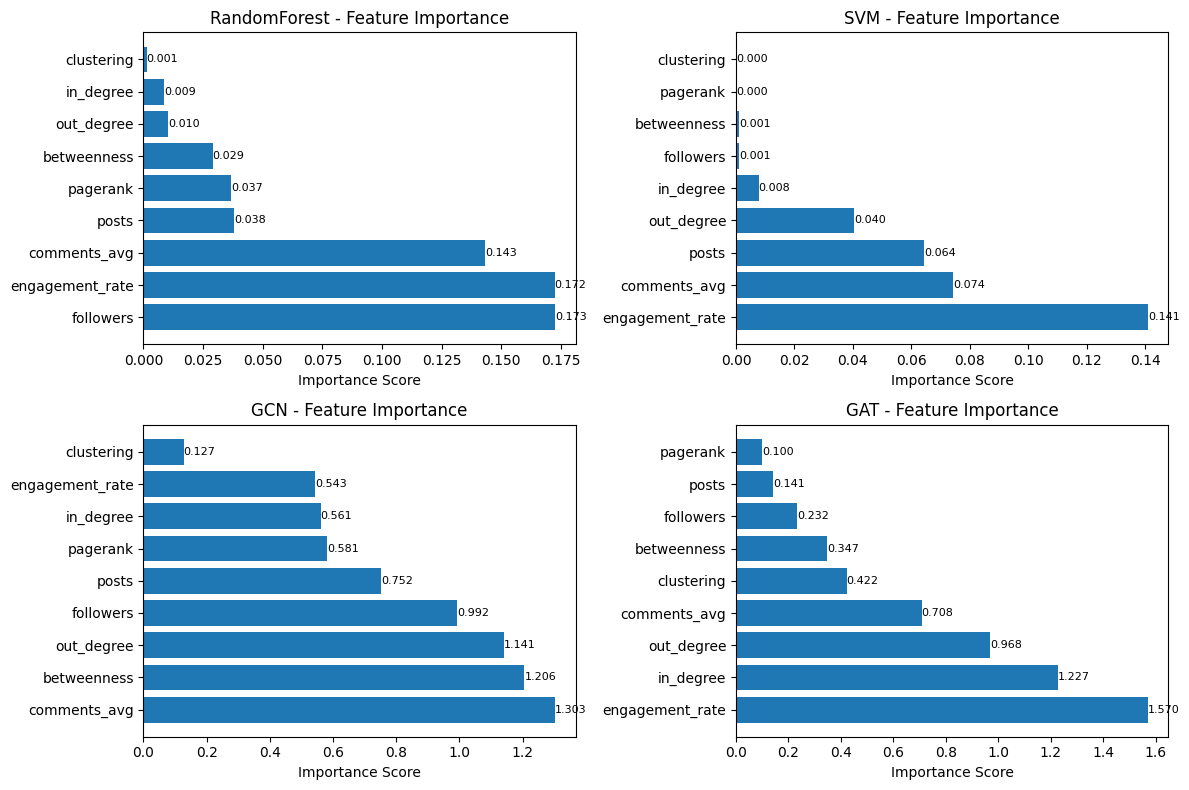

Feature importance comparison plot completed


In [73]:
# Explainable
analyzer = ExplainabilityAnalyzer(feature_names=feature_columns)
print("\nTraditional Model SHAP Analysis")
shap_results = analyzer.analyze_traditional_models(model_results, X_scaled[170:], y_cls[170:], y.values[170:])
print("\nGNN Captum Analysis")
gnn_models = {'GCN': gcn_trained, 'GAT': gat_trained}
gnn_results = analyzer.analyze_gnn_models(gnn_models, data_cls, indices[2])
print("\nFeature Importance Plot")
analyzer.plot_feature_importance(shap_results, gnn_results)

In [74]:
structure_targets = ['followers', 'in_degree', 'pagerank']
behavior_features = ['likes_avg', 'comments_avg', 'posts', 'engagement_rate']


X_behavior = nodes_df[behavior_features].fillna(0)

#Fitting a Normalizer Using Behavioral Features
scaler = StandardScaler()
scaler.fit(X_behavior)

#Transform
X_behavior_scaled = scaler.transform(X_behavior)

for target in structure_targets:
    y_target = nodes_df[target]
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_behavior_scaled, y_target)
    pred = rf.predict(X_behavior_scaled)
    mse = mean_squared_error(y_target, pred)
    r2 = r2_score(y_target, pred)
    pcc, _ = pearsonr(y_target, pred)
    print(f"Prediction results for {target} -> MSE: {mse:.2f}, R²: {r2:.4f}, PCC: {pcc:.4f}")

Prediction results for followers -> MSE: 130988340038611.16, R²: 0.9746, PCC: 0.9910
Prediction results for in_degree -> MSE: 1.36, R²: 0.8430, PCC: 0.9640
Prediction results for pagerank -> MSE: 0.00, R²: 0.9318, PCC: 0.9807


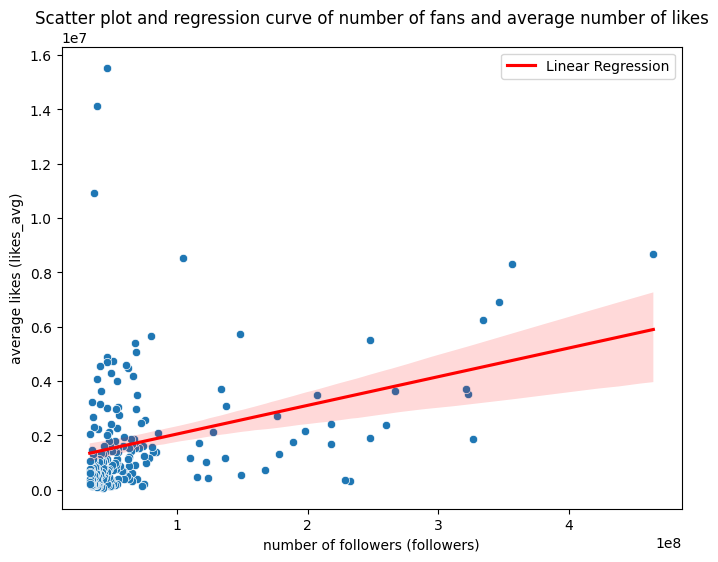

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


plt.figure(figsize=(8,6))
sns.scatterplot(x=nodes_df['followers'], y=nodes_df['likes_avg'])
sns.regplot(x=nodes_df['followers'], y=nodes_df['likes_avg'], scatter=False, color='red', label='Linear Regression')
plt.xlabel('number of followers (followers)')
plt.ylabel('average likes (likes_avg)')
plt.title('Scatter plot and regression curve of number of fans and average number of likes')
plt.legend()
plt.show()

In [76]:
from sklearn.preprocessing import StandardScaler

# Refit the scaler with full features
feature_columns = ['followers', 'posts', 'comments_avg', 'engagement_rate',
                   'in_degree', 'out_degree', 'pagerank', 'betweenness', 'clustering']

scaler = StandardScaler()
scaler.fit(nodes_df[feature_columns])
import joblib


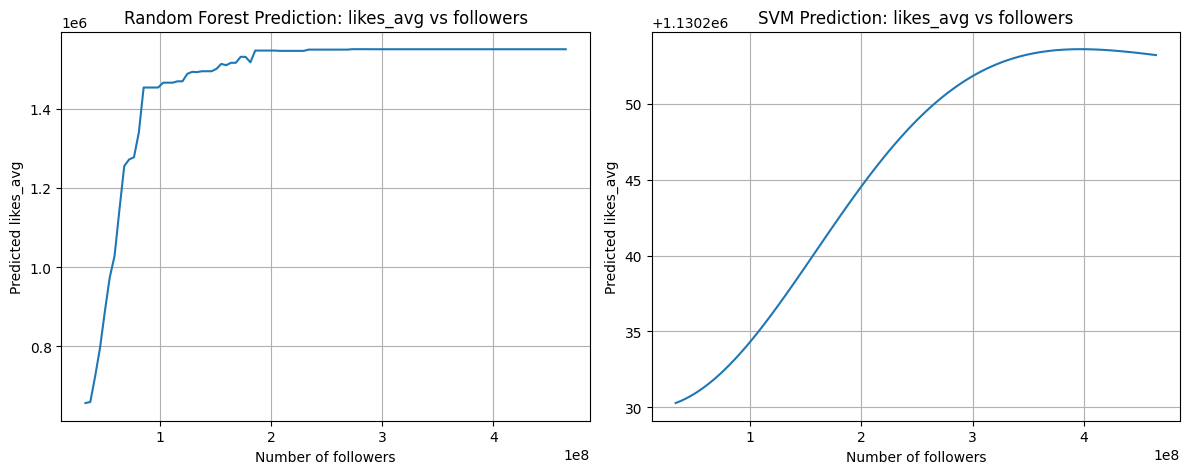

In [77]:
import numpy as np
import matplotlib.pyplot as plt
"""
Draw a trend chart of the prediction results of the traditional model as a single feature changes
- traditional_reg_model: trained random forest regression model, etc.
- scaler: StandardScaler for data standardization
- feature_name: the name of the feature to be simulated, such as 'followers'
- feature_range: the value range of the feature (np.array)
- fixed_features: fixed values of other features except feature_name (dict)
- feature_names: the order of the feature list, consistent with the model training
"""

def plot_traditional_model_prediction_vs_feature_subplot(ax, traditional_reg_model, scaler, feature_name, feature_range, fixed_features, feature_names, label_title):
    preds = []
    idx = feature_names.index(feature_name)

    for val in feature_range:
        x = np.array([fixed_features.get(f, 0) for f in feature_names], dtype=np.float32)
        x[idx] = val
        x_scaled = scaler.transform(x.reshape(1, -1))
        pred = traditional_reg_model.predict(x_scaled)[0]
        preds.append(pred)

    ax.plot(feature_range, preds, label=label_title, color='tab:blue')
    ax.set_xlabel('Number of followers')
    ax.set_ylabel('Predicted likes_avg')
    ax.set_title(label_title)
    ax.grid(True)

feature_columns = ['followers', 'posts', 'comments_avg', 'engagement_rate',
                   'in_degree', 'out_degree', 'pagerank', 'betweenness', 'clustering']
feature_name = 'followers'
feature_range = np.linspace(nodes_df[feature_name].min(), nodes_df[feature_name].max(), 100)
fixed_features = {f: nodes_df[f].median() for f in feature_columns}


fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# L：Random Forest
plot_traditional_model_prediction_vs_feature_subplot(
    ax=axes[0],
    traditional_reg_model=rf_model,
    scaler=scaler,
    feature_name=feature_name,
    feature_range=feature_range,
    fixed_features=fixed_features,
    feature_names=feature_columns,
    label_title='Random Forest Prediction: likes_avg vs followers'
)

# R：SVM
plot_traditional_model_prediction_vs_feature_subplot(
    ax=axes[1],
    traditional_reg_model=svm_model,
    scaler=scaler,
    feature_name=feature_name,
    feature_range=feature_range,
    fixed_features=fixed_features,
    feature_names=feature_columns,
    label_title='SVM Prediction: likes_avg vs followers'
)

plt.tight_layout()
plt.show()

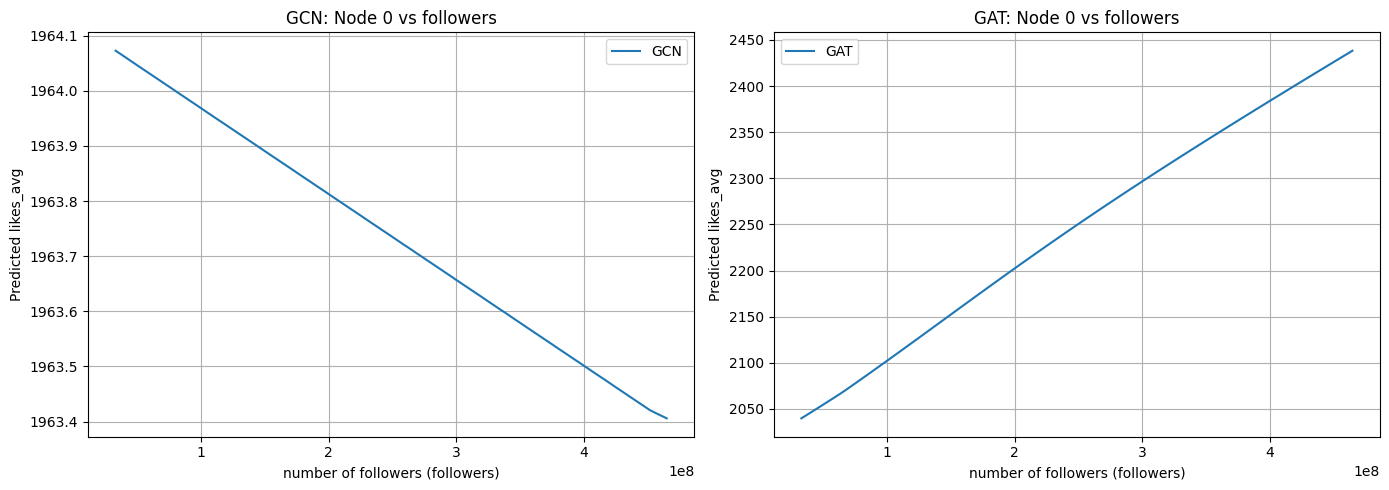

In [78]:
import matplotlib.pyplot as plt
import torch

# preprocessing
feature_columns = ['followers', 'posts', 'comments_avg', 'engagement_rate',
                   'in_degree', 'out_degree', 'pagerank', 'betweenness', 'clustering']

X = nodes_df[feature_columns].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pyg_data.x = torch.tensor(X_scaled, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
node_idx = 0
feature_name = 'followers'
feature_range = np.linspace(nodes_df[feature_name].min(), nodes_df[feature_name].max(), 100)


def plot_gnn_prediction_vs_feature_subplot(ax, model, pyg_data, scaler, node_idx, feature_name, feature_range, feature_names, device, label):
    model.eval()
    preds = []
    idx = feature_names.index(feature_name)
    edge_index = pyg_data.edge_index.to(device)

    for val in feature_range:
        x_np = scaler.inverse_transform(pyg_data.x.cpu().numpy())  # denormalization
        x_np[node_idx, idx] = val  # change the node's feature
        x_scaled = scaler.transform(x_np)
        x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)

        with torch.no_grad():
            out = model(x_tensor, edge_index, task='regression')
            pred = out[node_idx].item()
            preds.append(pred)

    ax.plot(feature_range, preds, label=label)
    ax.set_xlabel('number of followers (followers)')
    ax.set_ylabel('Predicted likes_avg')
    ax.set_title(f'{label}: Node {node_idx} vs {feature_name}')
    ax.grid(True)
    ax.legend()


fig, axes = plt.subplots(1, 2, figsize=(14, 5))



plot_gnn_prediction_vs_feature_subplot(
    ax=axes[0],
    model=gcn_model,
    pyg_data=pyg_data,
    scaler=scaler,
    node_idx=node_idx,
    feature_name=feature_name,
    feature_range=feature_range,
    feature_names=feature_columns,
    device=device,
    label='GCN'
)

plot_gnn_prediction_vs_feature_subplot(
    ax=axes[1],
    model=gat_model,
    pyg_data=pyg_data,
    scaler=scaler,
    node_idx=node_idx,
    feature_name=feature_name,
    feature_range=feature_range,
    feature_names=feature_columns,
    device=device,
    label='GAT'
)

plt.tight_layout()
plt.show()



